<b>【2025-06-05】 ルールの変更に伴い、「3.ルールの理解・OK/NGの体的な処理例」のスケーリング処理を修正いたしました。</b><br>

# SMBCグループ GREEN×DATA チャレンジ2025へようこそ！

SMBCグループ GREEN×DATA チャレンジ2025にご参加いただき、誠にありがとうございます。

このチュートリアルでは、「予測結果を投稿する」「ルールを理解する」ことを目的とした分析の出発点です。分析は[Google Colaboratory (Colab)](https://colab.research.google.com/) を用いて、データの読み込み、予測モデル構築、投稿ファイル作成までを 1 本の Notebook で体験します。Colab なら環境構築は不要でブラウザとGoogleアカウントさえあれば実行できます。

## 本チュートリアルの流れ

1. **Colabのセットアップ・データの読み込み**
2. **探索的データ分析**  
   - データを操作しながら、特徴量の選択・作成を行います。
3. **ルールの理解・OK/NGの体的な処理例**
   - “未来データの混入(=リーク)” とは何かをOK/NGの例（実際のコード）を見ながら把握します。
4. **モデリング**  
   - 3のOKの前処理を行い、線形回帰でモデリングを行います。
5. **予測・投稿**  
   - testデータの予測を行い、投稿ファイルを作成します。

---

* チュートリアルで使用するNotebookは「データ」ページからダウンロード可能です。
* 皆様の挑戦を心よりお待ちしております！

# 1. Colabのセットアップ・データの読み込み

## 1-1.Colabの使用方法

<p>ここでは、Colabの起動からGoogle Drive内のデータ読み込むための準備の手順を説明します。</p>

<h3>Colabの起動</h3>

1. Googleアカウントにログイン
2. ブラウザで <a href="https://colab.research.google.com/">Colab</a> にアクセス
3. 「新しいノートブック」をクリックして、新しいColab環境を立ち上げる

<h3>Google Driveのディレクトリ構成</h3>
<p>
今回はマイドライブの中に、以下のような構造でデータを置くことを前提とします。
</p>

```sh
マイドライブ/
├── data/
│   ├── train.csv
│   ├── test.csv
│   ├── sample_submission.csv
│   └── tutorial.ipynb
```

<h3>Google Driveへの接続方法</h3>

1. Colabノートブックを開いた状態で、以下のコードを実行して自分のGoogle Driveへ接続

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. 「Google Driveに接続」をクリックし、Googleアカウントを選択
3. 接続が成功すると、「Mounted at /content/drive」というメッセージが表示される
<p>
これで、自分のGoogle Drive に接続できました!<br>
以下のコードでマイドライブの中にあるフォルダを確認することもできます。
</p>

```sh
ls /content/drive/MyDrive/
```

## 1-2.ライブラリの読み込み

ライブラリを読み込むことで、pythonがある特定の分野に特化した処理を行うことができるようになります。<br>
このチュートリアルノートブックに必要なライブラリを読み込みましょう。<br>
今使用するライブラリの全てを読み込まなくても、必要に応じて都度ライブラリを読み込みながら進めることもできます。

In [2]:
# ライブラリのインポート
import os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

warnings.filterwarnings("ignore")

# 日本語フォントを簡単に使う
!pip -q install japanize-matplotlib
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 34.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


<h2> 1-3.データの読み込み</h2>

<p>それではデータを読み込んでみましょう。<br>
データを読み込むには pd.read_csv() を使います。<br>
マイドライブは/content/drive/の中にあるので、trainデータまでのパスは以下のようになります。</p>

In [8]:
########################################################
# 必要に応じてデータを格納したパスに変更してください。 #

data_path = '/content/drive/MyDrive/SIGNATE/SMBC Group GREEN×DATA Challenge 2025 for Recruiting/data/'
########################################################

In [9]:
train_df  = pd.read_csv(data_path + 'train.csv', index_col=0)
test_df   = pd.read_csv(data_path + 'test.csv', index_col=0)
sample_submission_df = pd.read_csv(data_path + 'sample_submit.csv', header=None)  # header 無し

これでデータを読み込むことができました！<br>以下のコードでどのようなデータが格納されているのかを確認します。

In [10]:
# 概要を確認
print("\n--- 学習データ (train_df) ---")
display(train_df.head())
print(f"shape: {train_df.shape}")

print("\n--- テストデータ (test_df) ---")
display(test_df.head())
print(f"shape: {test_df.shape}")

print("\n--- サンプル提出 (sample_submission_df) ---")
display(sample_submission_df.head())
print(f"shape: {sample_submission_df.shape}")


--- 学習データ (train_df) ---


,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,...,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon,price_actual
time,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,64.02
2015-01-02 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,58.46
2015-01-02 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.70
2015-01-02 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.91
2015-01-02 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,53.07


shape: (26280, 91)

--- テストデータ (test_df) ---


,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,...,seville_wind_speed,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+01:00,279.0,0.0,3927.0,895.0,189.0,230.0,1069.0,1893.0,7104.0,53.0,...,1,343,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2018-01-01 01:00:00+01:00,282.0,0.0,3948.0,878.0,177.0,1269.0,1058.0,1024.0,7101.0,52.0,...,1,343,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2018-01-01 02:00:00+01:00,283.0,0.0,3791.0,890.0,175.0,2197.0,1052.0,888.0,7100.0,52.0,...,1,0,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2018-01-01 03:00:00+01:00,280.0,0.0,3671.0,881.0,175.0,2965.0,1032.0,645.0,7101.0,53.0,...,1,40,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2018-01-01 04:00:00+01:00,286.0,0.0,3460.0,861.0,173.0,2705.0,1001.0,661.0,7101.0,53.0,...,1,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n


shape: (8760, 90)

--- サンプル提出 (sample_submission_df) ---


,0,1
0,2018-01-01 00:00:00+01:00,0
1,2018-01-01 01:00:00+01:00,0
2,2018-01-01 02:00:00+01:00,0
3,2018-01-01 03:00:00+01:00,0
4,2018-01-01 04:00:00+01:00,0


shape: (8760, 2)


In [11]:
# 情報や統計量を確認
print("\n--- 学習データ (train_df) ---")
display(train_df.info())
display(train_df.describe())
print()
print("\n--- テストデータ (test_df) ---")
display(test_df.info())
display(test_df.describe())


--- 学習データ (train_df) ---
<class 'pandas.core.frame.DataFrame'>
Index: 26280 entries, 2015-01-02 00:00:00+01:00 to 2017-12-31 23:00:00+01:00
Data columns (total 91 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           26259 non-null  float64
 1   generation_fossil_brown_coal/lignite         26260 non-null  float64
 2   generation_fossil_gas                        26260 non-null  float64
 3   generation_fossil_hard_coal                  26260 non-null  float64
 4   generation_fossil_oil                        26259 non-null  float64
 5   generation_hydro_pumped_storage_consumption  26259 non-null  float64
 6   generation_hydro_run_of_river_and_poundage   26259 non-null  float64
 7   generation_hydro_water_reservoir             26260 non-null  float64
 8   generation_nuclear                           26261 non-null  float64
 9   generat

None

,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,...,seville_pressure,seville_humidity,seville_wind_speed,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,price_actual
count,26259.000000,26260.000000,26260.000000,26260.000000,26259.000000,26259.000000,26259.000000,26260.000000,26261.000000,26260.000000,...,26280.000000,26280.00000,26280.000000,26280.000000,26280.000000,26280.000000,26280.0,26280.000000,26280.000000,26280.000000
mean,399.151719,480.261729,5559.830122,4447.482216,303.806009,504.322899,888.150844,2507.795316,6323.681200,62.500685,...,1019.224543,62.65898,2.424353,149.538661,0.039498,0.000243,0.0,13.740601,774.138927,56.028338
std,89.897230,365.334152,2272.017312,2027.884207,54.036443,804.870327,369.509637,1869.150134,827.939857,21.451727,...,6.846954,23.31406,1.839498,104.268808,0.204880,0.003961,0.0,25.801707,85.866724,14.340356
min,0.000000,0.000000,1518.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,993.000000,7.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,200.000000,9.330000
25%,341.000000,0.000000,4071.000000,2624.000000,268.000000,0.000000,595.000000,955.000000,5900.000000,53.000000,...,1014.000000,44.00000,1.000000,50.000000,0.000000,0.000000,0.0,0.000000,800.000000,47.617500
50%,378.000000,564.000000,4866.000000,4764.000000,303.000000,90.000000,795.000000,1991.000000,6734.000000,58.000000,...,1018.000000,66.00000,2.000000,168.000000,0.000000,0.000000,0.0,0.000000,800.000000,55.930000
75%,480.000000,863.000000,6264.000000,6107.000000,336.000000,696.000000,1148.000000,3666.000000,7071.000000,84.000000,...,1024.000000,82.00000,3.000000,230.000000,0.000000,0.000000,0.0,20.000000,800.000000,65.192500
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,1939.000000,9389.000000,7116.000000,106.000000,...,1090.000000,100.00000,15.000000,360.000000,3.000000,0.095000,0.0,100.000000,804.000000,116.800000




--- テストデータ (test_df) ---
<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 2018-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 90 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           8758 non-null   float64
 1   generation_fossil_brown_coal/lignite         8758 non-null   float64
 2   generation_fossil_gas                        8758 non-null   float64
 3   generation_fossil_hard_coal                  8758 non-null   float64
 4   generation_fossil_oil                        8758 non-null   float64
 5   generation_hydro_pumped_storage_consumption  8758 non-null   float64
 6   generation_hydro_run_of_river_and_poundage   8758 non-null   float64
 7   generation_hydro_water_reservoir             8758 non-null   float64
 8   generation_nuclear                           8758 non-null   float64
 9   generat

None

,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,...,seville_temp_max,seville_pressure,seville_humidity,seville_wind_speed,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id
count,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.0,8760.000000,8760.000000
mean,336.875771,352.930121,5810.462206,3689.136675,282.176639,388.825074,1223.473624,2898.403859,6085.006394,53.418703,...,291.589474,1016.417237,67.122831,2.656849,159.225913,0.046164,0.000001,0.0,15.477283,771.580708
std,44.562788,300.150290,1967.569086,1618.806576,43.622782,746.575384,385.951826,1698.149263,850.307688,14.041959,...,7.591655,6.404969,21.208030,1.944383,104.161822,0.244303,0.000128,0.0,27.228189,91.783368
min,0.000000,0.000000,0.000000,700.000000,44.000000,0.000000,467.000000,310.000000,998.000000,0.000000,...,272.150000,986.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,200.000000
25%,309.000000,0.000000,4325.000000,2284.250000,248.000000,0.000000,918.000000,1519.250000,5062.000000,53.000000,...,286.150000,1013.000000,51.000000,1.000000,50.000000,0.000000,0.000000,0.0,0.000000,800.000000
50%,348.000000,414.000000,5287.000000,3815.000000,291.000000,17.000000,1203.000000,2609.000000,6071.000000,57.000000,...,290.150000,1016.000000,71.000000,2.000000,190.000000,0.000000,0.000000,0.0,0.000000,800.000000
75%,371.000000,635.750000,6812.500000,5090.750000,317.000000,386.000000,1566.000000,3956.000000,6979.000000,59.000000,...,296.150000,1020.000000,87.000000,4.000000,230.000000,0.000000,0.000000,0.0,20.000000,800.000000
max,413.000000,959.000000,13292.000000,6928.000000,364.000000,4218.000000,2000.000000,9728.000000,7117.000000,83.000000,...,316.150000,1037.000000,100.000000,14.000000,360.000000,3.000000,0.012000,0.0,100.000000,804.000000


90ほどのたくさんの特徴量がありますが、`Non-Null Count`から欠損値がほとんどないこともわかります。<br>
次の章では、この中からモデリングに使用すべき特徴量が何かを判断するために、学習データの分析を行います。

# 2. 探索的データ分析

本チュートリアルでは、以下の仮説のもと特徴量を絞ってデータ分析を行います。
1. 価格`price_actual`は、主に需要と供給のバランスによって決定される（データタブ参照）ので、24時間前の需要`total_load_actual`も影響があるのではないか
2. 発電コストがかかる化石燃料系`fossil_gas` / `fossil_coal` / `fossil_oil`による供給が多いと価格`price_actual`が上がるのではないか
3. 再生可能エネルギー`solar` / `wind` / `hydro`による供給が多いと価格が下がるのではないか
4. 気温`temp`が極端だと電力の需要が高まり、価格が上がるのではないか

特徴量を絞ったら、目的変数とどのような関係があるか、相関係数を可視化していきます。

In [12]:
base_features = [
    "total_load_actual",
    "generation_fossil_gas",
    "generation_fossil_hard_coal",
    "generation_fossil_oil",
    "generation_solar",
    "generation_wind_onshore",
    "generation_hydro_run_of_river_and_poundage",
    "valencia_temp",
    "price_actual"      # ← 目的変数
]

train_sub = train_df[base_features].copy()
test_sub = test_df[base_features[:-1]].copy() #testデータでは目的変数以外の特徴量を選択

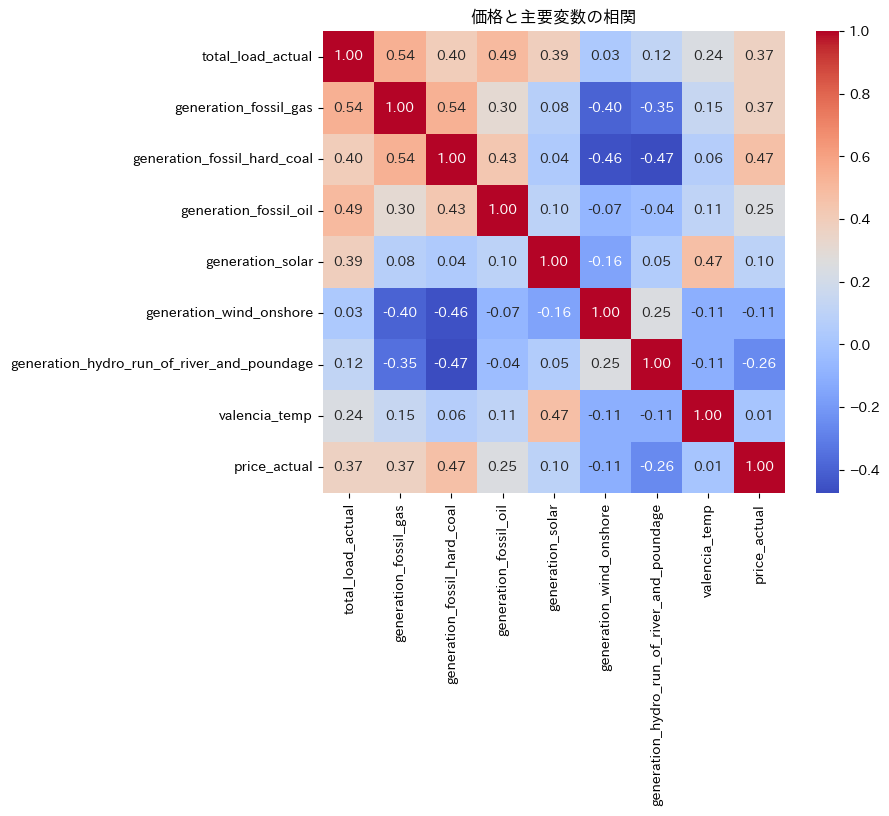

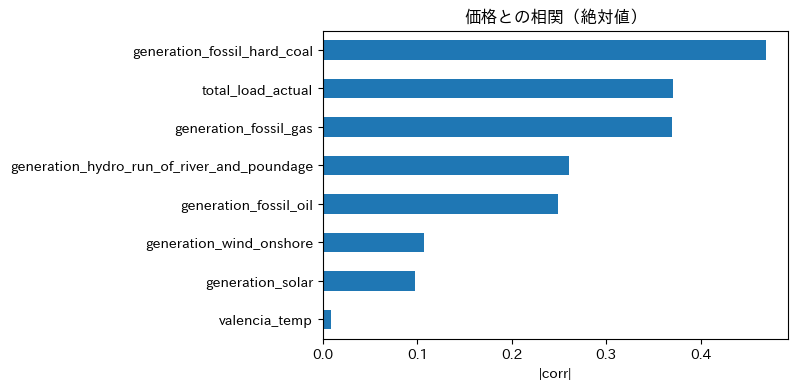

In [13]:
corr = train_sub.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("価格と主要変数の相関")
plt.show()
print()
abs_corr = corr["price_actual"].drop("price_actual").abs().sort_values(ascending=True)
abs_corr.plot(kind="barh", figsize=(6,4))
plt.title("価格との相関（絶対値）")
plt.xlabel("|corr|")
plt.show()

可視化した結果、以下のことが読み取れます。<br>
・目的変数`price_actual`は以下の特徴量と正の相関がある
- 化石燃料系`generation_fossil_hard_coal`, `generation_fossil_gas`, `generation_fossil_oil`
- 電力需要`total_load_actual`

<b>→「高コストの火力が増える」「電力需要が高い」と電力価格が上がる傾向</b><br>
<br>

・逆に再生可能エネルギー`generation_hydro_run_of_river_and_poundage`, `generation_wind_onshore`とは負の相関がある

<b>→「再エネの比率が高い」と電力価格が下がる傾向</b><br>
<br>

・気温`valencia_temp`との相関は小さい

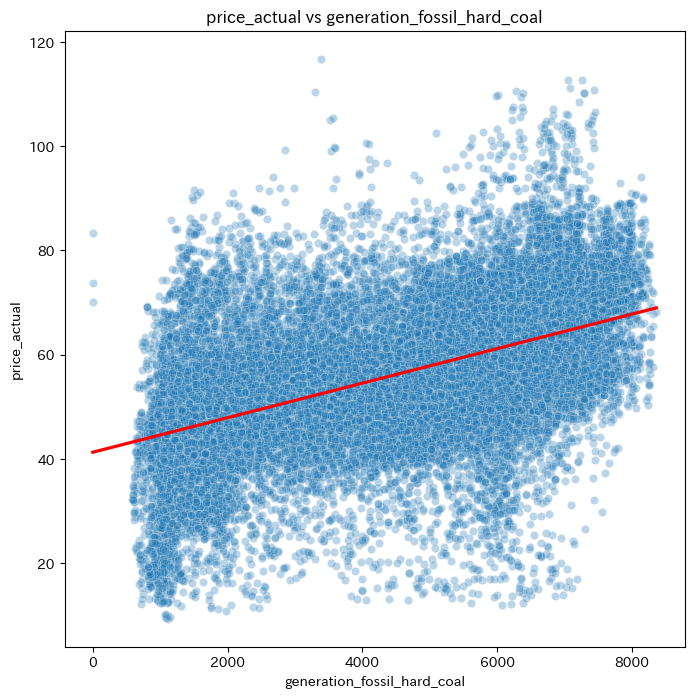

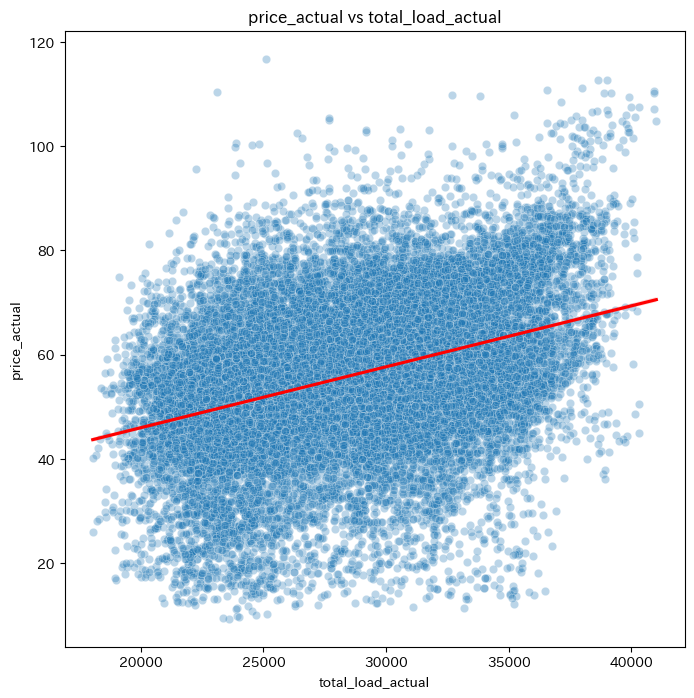

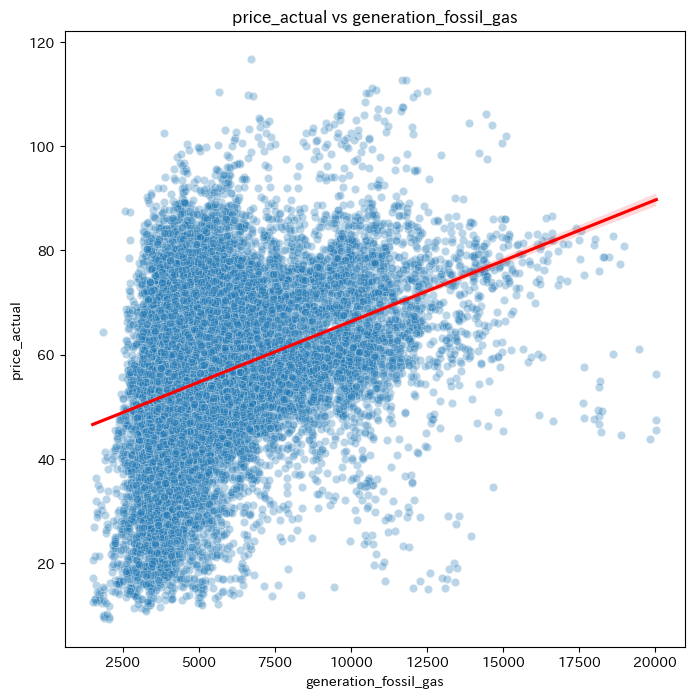

In [14]:
# 目的変数と特に相関が高い3つの特徴量の散布図を可視化
top3 = abs_corr.sort_values(ascending=False).head(3).index.tolist()

for col in top3:
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=train_sub[col], y=train_sub["price_actual"], alpha=0.3)
    sns.regplot(x=train_sub[col], y=train_sub["price_actual"],
                scatter=False, color="red")
    plt.title(f"price_actual vs {col}")
    plt.show()

続いて、気温が極端（暑すぎる、寒すぎる）な場合、電力価格`price_actual`に影響があるかを確認します。<br>
確認の方法は、快適な温度を20℃と仮定したとき、その快適な温度から離れるほど価格が高くなるかを可視化します。

In [ ]:
COMFORT = 20.0 # 快適温度 ≈ 20 ℃ と仮定
train_sub["temp_C"] = train_sub["valencia_temp"] - 273.15 # ケルビンから摂氏に変換
train_sub["temp_dev"] = (train_sub["temp_C"] - COMFORT).abs() # 20℃からどれぐらい離れているかを計算しtemp_devという特徴量を作成

# testデータにも同様の特徴量を追加
test_sub["temp_C"] = test_sub["valencia_temp"] - 273.15
test_sub["temp_dev"] = (test_sub["temp_C"] - COMFORT).abs()

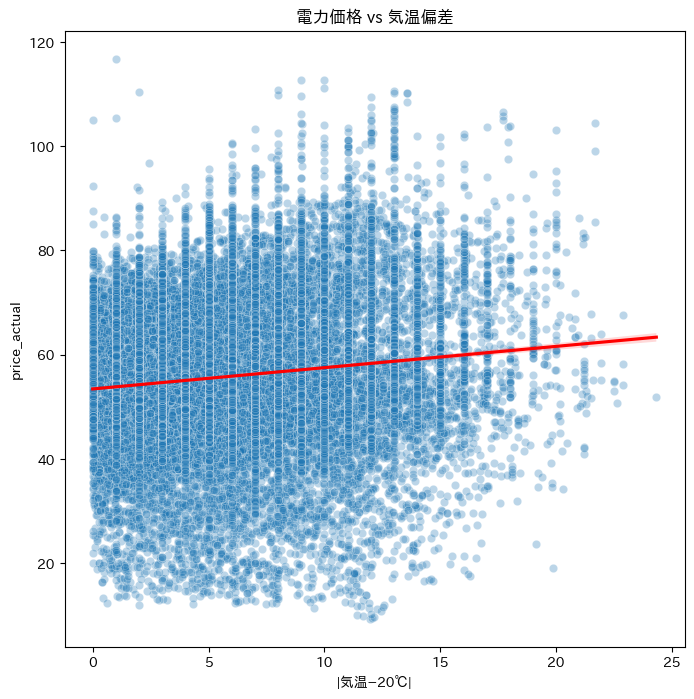

In [ ]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=train_sub["temp_dev"], y=train_sub["price_actual"], alpha=0.3)
sns.regplot(x=train_sub["temp_dev"], y=train_sub["price_actual"],
            scatter=False, color="red")
plt.xlabel("|気温−20℃|")
plt.ylabel("price_actual")
plt.title("電力価格 vs 気温偏差")
plt.show()

In [ ]:
corr_temp = train_sub["temp_dev"].corr(train_sub["price_actual"])
print(f"気温偏差と需要の相関: {corr_temp:.4f}")

気温偏差と需要の相関: 0.1217


この結果から、快適な気温から離れるほど、電力価格が<b>少し上昇する</b>傾向があることがわかりました。

ここまでの結果から以下の特徴量をモデリングに採用します。
- `total_load_actual`
- `generation_solar`
- `generation_wind_onshore`
- `generation_hydro_run_of_river_and_poundage`
- `generation_fossil_gas`
- `generation_fossil_hard_coal`
- `generation_fossil_oil`
- `temp_dev`

In [ ]:
select_col = [
    'total_load_actual',
    'generation_solar',
    'generation_wind_onshore',
    'generation_hydro_run_of_river_and_poundage',
    'generation_fossil_gas',
    'generation_fossil_hard_coal',
    'generation_fossil_oil',
    'temp_dev',
    'price_actual',
]
train_selected = train_sub[select_col]
test_selected = test_sub[select_col[:-1]]

## 3. ルールの理解・OK/NGの体的な処理例

時系列コンペでは「未来データの混入(=リーク)」が最大の落とし穴です。  
下表では、比較的使われる前処理・特徴量作成手法について **“どこまでが OK で、どこからが NG か”** を具体例付きで整理しました。  
まずは全体像を把握し、自分のパイプラインが OK の列に収まっているか確認しましょう。

まず、直前の数値（直前がNaNの場合は最も近い過去の数値）で欠損値補完を行います。その後、本チュートリアルでは1の「スケーリング」処理のみ、OK/NGのそれぞれの具体的なコードを確認します。

In [ ]:
# 欠損値補完
train_selected.ffill(inplace=True)
test_selected.ffill(inplace=True)

「スケーリング」の処理例<br>

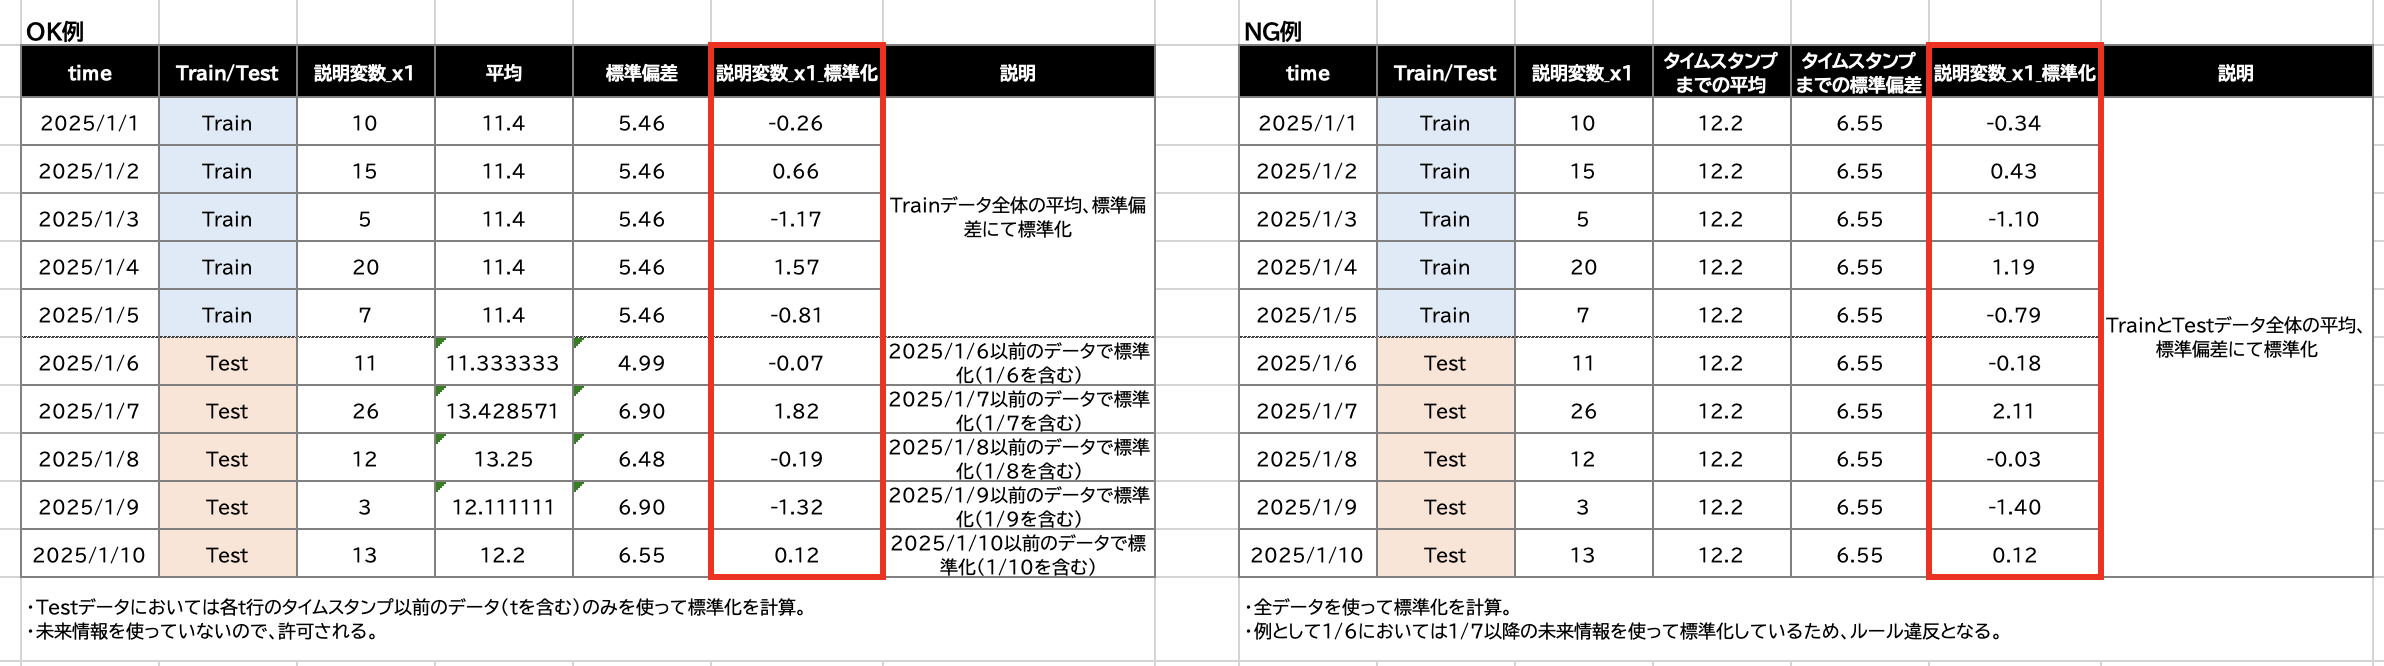

In [ ]:
# 目的変数以外のカラムを標準化
scale_cols = [c for c in train_selected.columns if c != "price_actual"]
# OK / NGをそれぞれ別のデータフレームで作成
train_ok = train_selected.copy()
train_ng = train_selected.copy()
test_ok = test_selected.copy()
test_ng = test_selected.copy()

In [ ]:
# train データ：StandardScaler で一括標準化
scaler = StandardScaler()
scaled_arr = scaler.fit_transform(train_ok[scale_cols])
for i, col in enumerate(scale_cols):
    train_ok[f"{col}_scaled"] = scaled_arr[:, i]          # ← index はそのまま

# test データ：逐次標準化
# 時系列順に連結
df_all = (pd.concat([train_ok.assign(dataset='Train'),
                     test_ok.assign(dataset='Test')])
          .sort_index())

# expanding() で「その行まで」の平均・標準偏差
for col in scale_cols:
    df_all[f'{col}_mean_to_t'] = df_all[col].expanding().mean()
    df_all[f'{col}_std_to_t']  = df_all[col].expanding().std(ddof=0)

    mask_test = df_all['dataset'] == 'Test'
    df_all.loc[mask_test, f'{col}_scaled'] = (
        (df_all.loc[mask_test, col] - df_all.loc[mask_test, f'{col}_mean_to_t']) /
        df_all.loc[mask_test, f'{col}_std_to_t'].replace(0, np.nan)
    )

# train / test に切り戻す
cols_to_drop = (['dataset']
                + [f'{c}_mean_to_t' for c in scale_cols]
                + [f'{c}_std_to_t'  for c in scale_cols])

train_ok = df_all[df_all['dataset'] == 'Train'].drop(columns=cols_to_drop).copy()
test_ok  = df_all[df_all['dataset'] == 'Test' ].drop(columns=cols_to_drop).copy()


In [ ]:
# NG 版：testデータの全期間の平均・標準偏差で標準化（未来リーク）

# testデータの処理
scaler_ng = StandardScaler()
test_ng_scaled_arr = scaler_ng.fit_transform(test_ng[scale_cols])   # ← 未来リーク！

for i, col in enumerate(scale_cols):
    test_ng[f"{col}_scaled"] = test_ng_scaled_arr[:, i]

In [ ]:
print("◆ OK（リークなし）")
display(test_ok[[*(f"{c}_scaled" for c in scale_cols) ]].head())

print("\n◆ NG（未来情報で標準化：参考）")
display(test_ng[[*(f"{c}_scaled" for c in scale_cols) ]].head())

◆ OK（リークなし）


,total_load_actual_scaled,generation_solar_scaled,generation_wind_onshore_scaled,generation_hydro_run_of_river_and_poundage_scaled,generation_fossil_gas_scaled,generation_fossil_hard_coal_scaled,generation_fossil_oil_scaled,temp_dev_scaled
time,,,,,,,,
2018-01-01 00:00:00+01:00,-0.949821,-0.841647,0.622624,0.488898,-0.718680,-1.751300,-2.125044,-0.554264
2018-01-01 01:00:00+01:00,-1.400203,-0.851696,0.604979,0.459115,-0.709416,-1.759544,-2.346840,-0.085895
2018-01-01 02:00:00+01:00,-1.709460,-0.856410,0.605593,0.442866,-0.778507,-1.753492,-2.383549,0.148290
2018-01-01 03:00:00+01:00,-1.902211,-0.856382,0.707573,0.388724,-0.831308,-1.757792,-2.383246,0.382475
2018-01-01 04:00:00+01:00,-1.982441,-0.856946,0.783736,0.304809,-0.924165,-1.767512,-2.419935,0.616655



◆ NG（未来情報で標準化：参考）


,total_load_actual_scaled,generation_solar_scaled,generation_wind_onshore_scaled,generation_hydro_run_of_river_and_poundage_scaled,generation_fossil_gas_scaled,generation_fossil_hard_coal_scaled,generation_fossil_oil_scaled,temp_dev_scaled
time,,,,,,,,
2018-01-01 00:00:00+01:00,-1.037444,-0.806324,0.539616,-0.400401,-0.957267,-1.726028,-2.135955,-0.558954
2018-01-01 01:00:00+01:00,-1.480237,-0.816582,0.522750,-0.428906,-0.946592,-1.736529,-2.411054,-0.057250
2018-01-01 02:00:00+01:00,-1.784360,-0.821410,0.523352,-0.444454,-1.026396,-1.729116,-2.456904,0.193602
2018-01-01 03:00:00+01:00,-1.974005,-0.821410,0.620935,-0.496280,-1.087393,-1.734676,-2.456904,0.444454
2018-01-01 04:00:00+01:00,-2.053059,-0.822013,0.693821,-0.576611,-1.194646,-1.747031,-2.502754,0.695306


以下、その他の前処理のOK/NGのイメージを掲載します。ぜひ参考にしてください。

「説明変数のカテゴリ統計量」の処理例

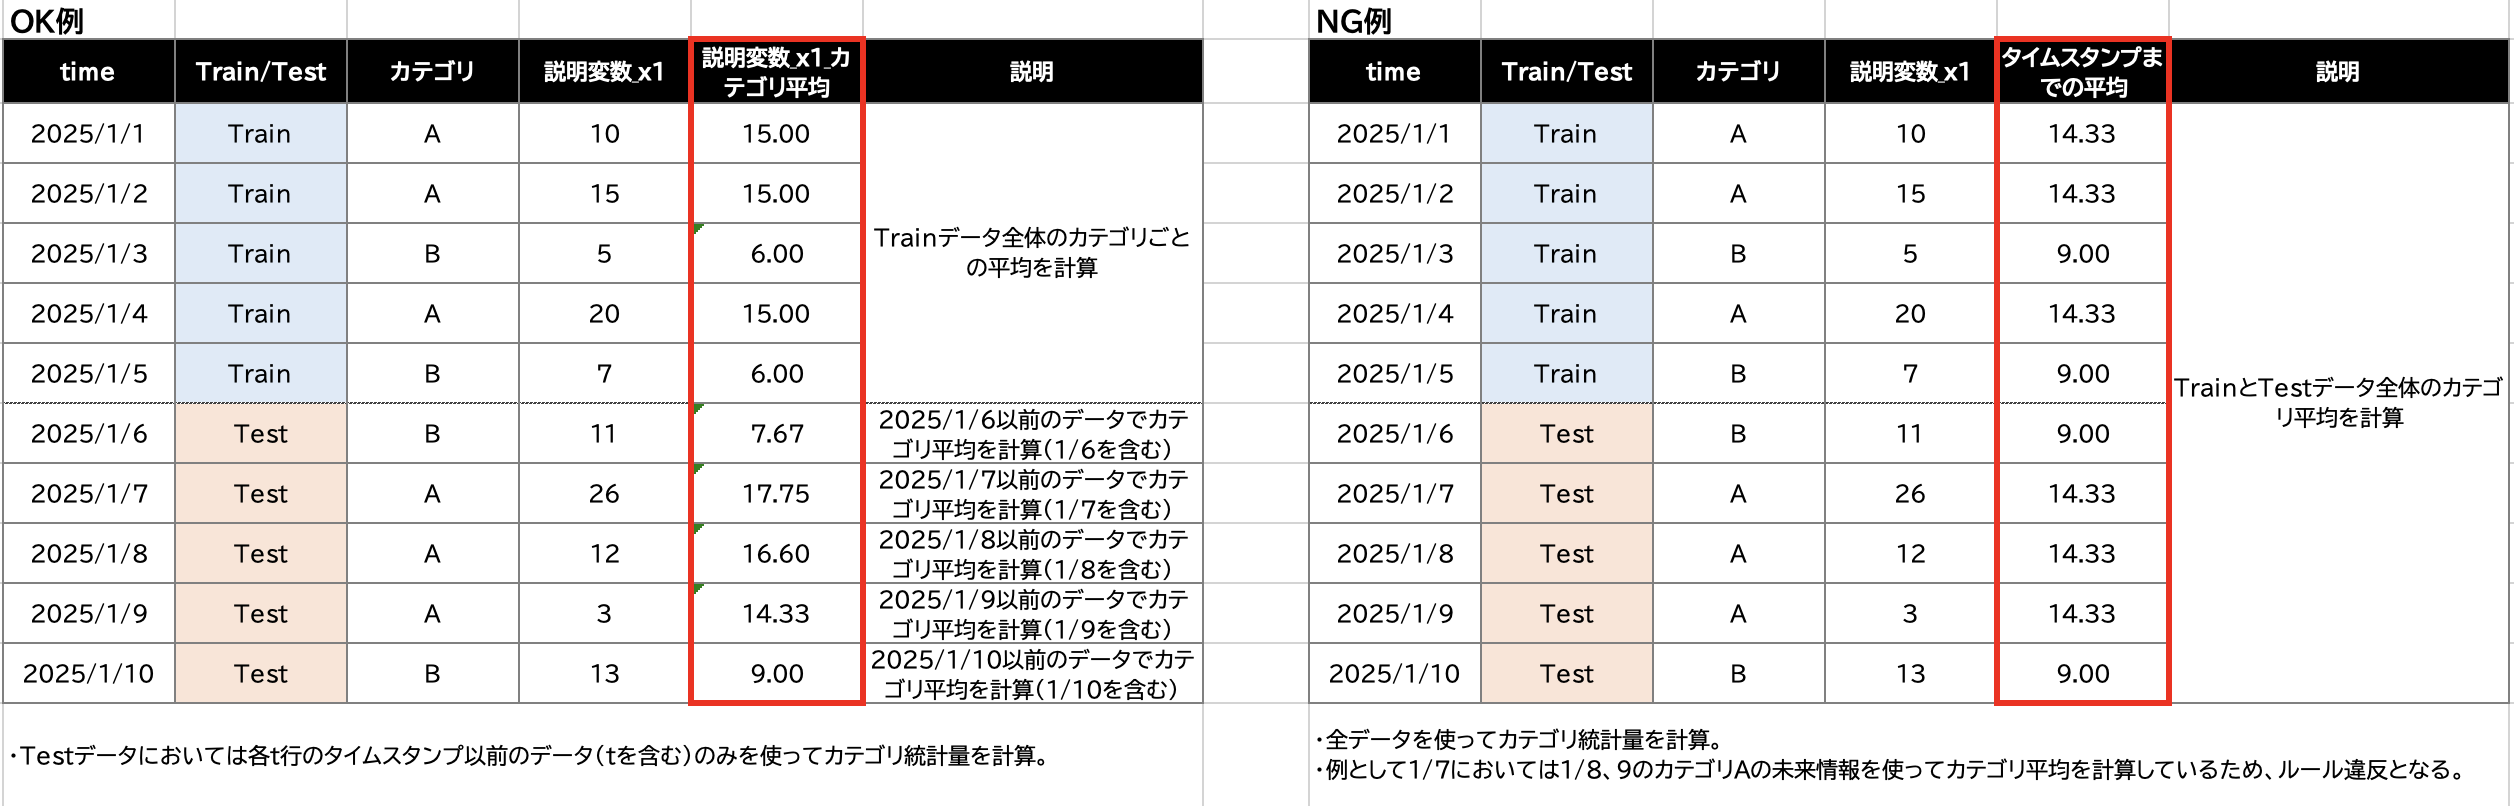

「擬似ラベル」の処理例

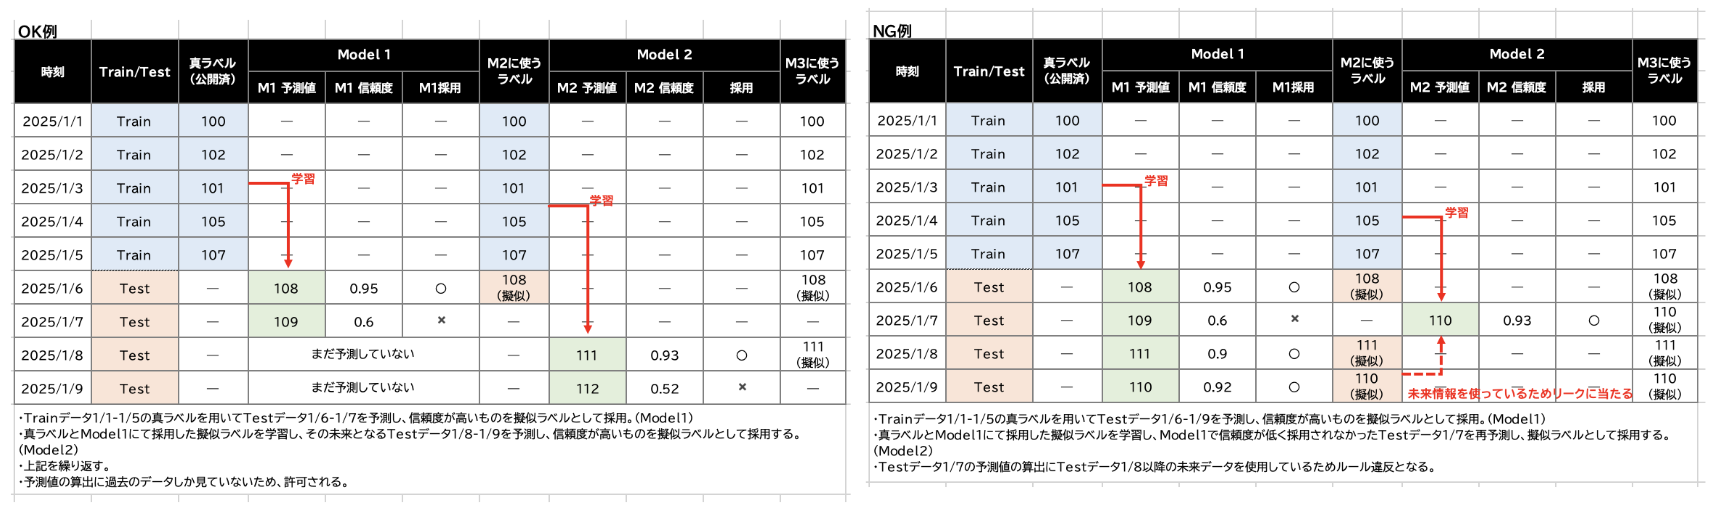

「スタッキング」の処理例

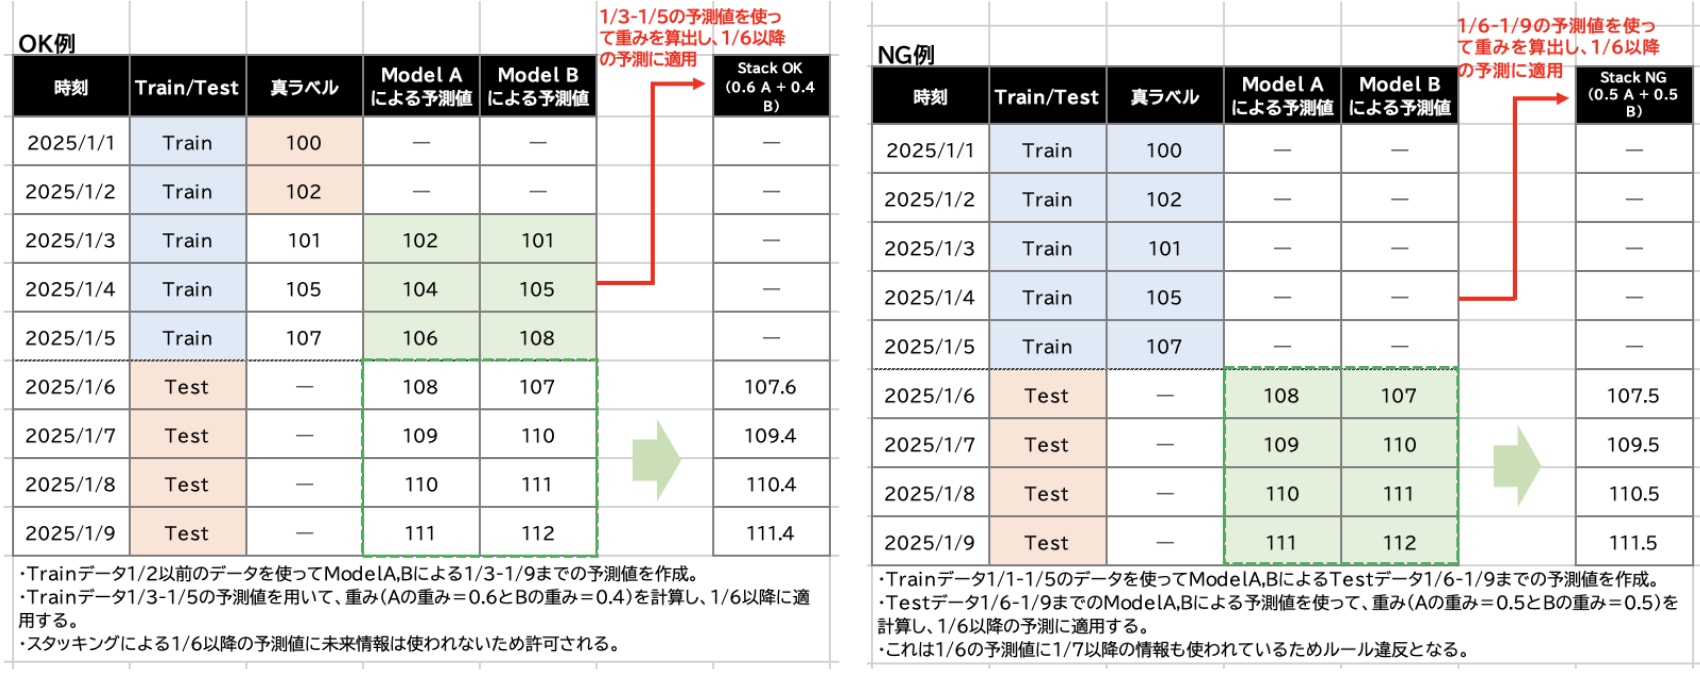

## 4. モデリング

モデリングをするため、次の準備を行います。
1. 学習用データセットを学習用 (2017年以前) と検証用 (2017年) のデータセットへ分割
2. 学習用データセットに含まれる特徴量と目的変数の分離

In [ ]:
train_ok

,total_load_actual,generation_solar,generation_wind_onshore,generation_hydro_run_of_river_and_poundage,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,temp_dev,price_actual,total_load_actual_scaled,generation_solar_scaled,generation_wind_onshore_scaled,generation_hydro_run_of_river_and_poundage_scaled,generation_fossil_gas_scaled,generation_fossil_hard_coal_scaled,generation_fossil_oil_scaled,temp_dev_scaled
time,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00+01:00,25385.0,49.0,6378.0,1051.0,4844.0,4821.0,162.0,21.921,64.02,-0.701992,-0.832784,0.301538,0.440192,-0.315020,0.184066,-2.624996,3.642475
2015-01-02 01:00:00+01:00,24382.0,50.0,5890.0,1009.0,5196.0,4755.0,158.0,21.921,58.46,-0.922388,-0.832191,0.147913,0.326517,-0.160063,0.151528,-2.699030,3.642475
2015-01-02 02:00:00+01:00,22734.0,50.0,5461.0,973.0,4857.0,4581.0,157.0,22.486,54.70,-1.284514,-0.832191,0.012861,0.229081,-0.309297,0.065747,-2.717539,3.774787
2015-01-02 03:00:00+01:00,21286.0,50.0,5238.0,949.0,4314.0,4131.0,160.0,22.486,54.91,-1.602693,-0.832191,-0.057340,0.164124,-0.548336,-0.156101,-2.662013,3.774787
2015-01-02 04:00:00+01:00,20264.0,42.0,4935.0,953.0,4130.0,3840.0,156.0,22.486,53.07,-1.827264,-0.836933,-0.152726,0.174950,-0.629337,-0.299563,-2.736047,3.774787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00+01:00,29018.0,59.0,7747.0,1140.0,3960.0,1039.0,208.0,3.000,39.90,0.096312,-0.826856,0.732508,0.681075,-0.704174,-1.680445,-1.773605,-0.788459
2017-12-31 20:00:00+01:00,29365.0,39.0,7595.0,1160.0,3918.0,1053.0,220.0,3.000,39.54,0.172561,-0.838711,0.684657,0.735206,-0.722663,-1.673543,-1.551503,-0.788459
2017-12-31 21:00:00+01:00,29311.0,36.0,7599.0,1158.0,3867.0,1048.0,228.0,4.000,32.90,0.160695,-0.840489,0.685916,0.729793,-0.745114,-1.676008,-1.403435,-0.554278


In [ ]:
# yearで分割するためindexをDatetimeIndex化
train_ok.index = pd.to_datetime(train_ok.index, errors="coerce", utc=True)
train_ok.index = train_ok.index.tz_convert("Etc/GMT-1")

# 2017 年をバリデーションに分割
val_mask = train_ok.index.year == 2017
train_mask = ~val_mask

In [ ]:
# 標準化した特徴量のみを選択
feature_cols = [c for c in train_ok.columns if c.endswith("_scaled")]

X_train = train_ok.loc[train_mask, feature_cols]
y_train = train_ok.loc[train_mask, 'price_actual']
X_val = train_ok.loc[val_mask, feature_cols]
y_val = train_ok.loc[val_mask, 'price_actual']
X_test = test_ok[feature_cols]

print(f"train rows: {len(X_train)}   val rows: {len(X_val)}")

train rows: 17520   val rows: 8760


表データの回帰問題には勾配ブースティング系（LightGBM など）が定番ですが、  
本チュートリアルは **線形回帰** でベースラインを作ります。  
線形回帰は

1. **シンプル & 高速**  
   * 係数と切片のみ。ハイパーパラメータ調整が不要  
   * スケーリング済み数値をそのまま投入し、学習は一瞬で完了
2. **解釈しやすい**  
   * 各係数が「特徴量が 1 上がると予測値が何だけ増減するか」を示す  
   * どの要因が価格に効いているかが直感的に分かる

という長所があり、**ルールを守った前処理が機能しているか** を手早く確認するのに最適です。

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

これでモデルの学習が完了しました。<br>
あらかじめ分けておいた検証用データで訓練済みモデルの予測性能を確認しましょう。<br>
本コンペティションで使用する評価指標はRMSEですのでscikit-learnからroot_mean_squared_errorを呼び出して評価します。

In [ ]:
y_pred = model.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print("\n=== 2017 Validation Metrics ===")
print(f"RMSE: {rmse:,.3f}")


=== 2017 Validation Metrics ===
RMSE: 11.716


## 5. 予測・投稿

最後に学習したモデルでテストデータ予測し、投稿ファイルを作成します。

In [ ]:
y_test_pred = model.predict(X_test)

テストデータの予測ができました。<br>
見本のsample_submission.csvを用いて投稿ファイルを作成しましょう。

In [ ]:
# sample_submission に書き込み & 保存
sample_submission_df[1] = y_test_pred

In [ ]:
sample_submission_df

,0,1
0,2018-01-01 00:00:00+01:00,39.313365
1,2018-01-01 01:00:00+01:00,39.090518
2,2018-01-01 02:00:00+01:00,38.879577
3,2018-01-01 03:00:00+01:00,39.070443
4,2018-01-01 04:00:00+01:00,39.189745
...,...,...
8755,2018-12-31 19:00:00+01:00,44.120324
8756,2018-12-31 20:00:00+01:00,45.109389
8757,2018-12-31 21:00:00+01:00,45.615694
8758,2018-12-31 22:00:00+01:00,45.333600


In [ ]:
sample_submission_df.to_csv(data_path+'tutorial.csv', header=False, index=False)

これで本チュートリアルは終了です。<br>
早速作成したsubmission_tutorial.csvを投稿してみましょう。<br>
コンペサイトの投稿ボタンから投稿可能です。

次のステップはスコアアップです。<br>
以下の観点をヒントにモデリングしてみてください！
- 需要`total_load_actual`は現時点から24時間前の数値です。天候などの情報から、より現時点に近い需要予測特徴量を作成してみましょう。
- 今回のモデルは線形回帰ですが、時系列データということも踏まえてさまざまなモデルを使ってみましょう